# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
path = Path('data/composers/notewise/piano_solo/note_range38/sample_freq12')

In [4]:
bs=64
# full precision max = 32
bptt=250

In [5]:
data = TextLMDataBunch.load(path, bs=bs, bptt=bptt)

In [6]:
vocab = data.train_ds.vocab
vocab_sz = len(vocab.itos); vocab_sz

110

In [7]:
t = data.train_ds[0][0]
t.text[:50], t.data

('xxbos wait25 wait25 wait25 wait25 wait25 wait25 wa',
 array([  2,  94,  94,  94, ...,   9,  53,   9, 109]))

In [8]:
class LMTrainer(LearnerCallback):
    "`Callback` that regroups lr adjustment to seq_len, AR and TAR."
    def __init__(self, learn):
        super().__init__(learn)
        
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies mixup to `last_input` and `last_target` if `train`."
        position_ids = torch.arange(last_input.shape[-1], dtype=torch.long, device=last_input.device)
        position_ids = position_ids.unsqueeze(0).expand_as(last_input)
        target_ids = torch.arange(last_target.shape[-1], dtype=torch.long, device=last_target.device)
        target_ids = target_ids.unsqueeze(0).expand_as(last_target)
        return (last_input, position_ids, last_target, target_ids), last_target[:, 1:]

### Transformer Arch
Paper: https://arxiv.org/abs/1706.03762  
Inspiration: https://github.com/jadore801120/attention-is-all-you-need-pytorch

In [9]:
import transformer.Constants as Constants
# from dataset import TranslationDataset, paired_collate_fn
from transformer.Models import Transformer
from transformer.Optim import ScheduledOptim

In [10]:
transformer = Transformer(
    n_src_vocab=vocab_sz,
    n_tgt_vocab=vocab_sz,
    len_max_seq=data.bptt+data.max_len,
#     len_max_seq=opt.max_token_seq_len,
#     tgt_emb_prj_weight_sharing=opt.proj_share_weight,
#     emb_src_tgt_weight_sharing=opt.embs_share_weight,
#     d_k=opt.d_k,
#     d_v=opt.d_v,
#     d_model=opt.d_model,
#     d_word_vec=opt.d_word_vec,
#     d_inner=opt.d_inner_hid,
#     n_layers=opt.n_layers,
#     n_head=opt.n_head,
#     dropout=opt.dropout
)

### Create Language learner

In [11]:
learn = LanguageLearner(data, transformer, bptt=bptt, clip=0.5)
learn.callbacks = [LMTrainer(learn)]
learn = learn.to_fp16(loss_scale=256)
learn.unfreeze()

In [ ]:
learn.lr_find()

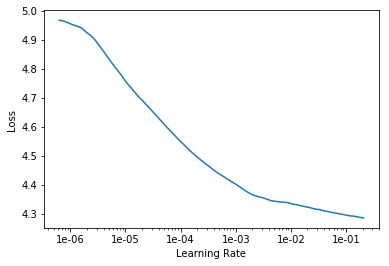

In [15]:
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(1, 1e-4, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,1.581177,1.448558,0.559073


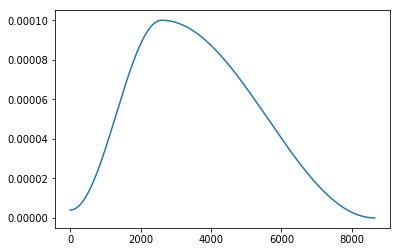

In [15]:
learn.recorder.plot_lr()

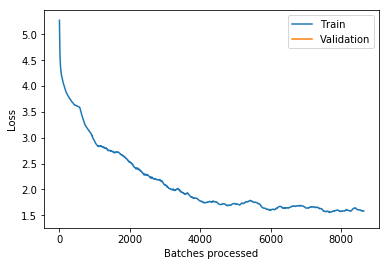

In [16]:
learn.recorder.plot_losses()

In [17]:
learn.save('transformer_run1_1en4');

### Epochs 7

In [15]:
learn.load('transformer_run1_1en4');
learn.unfreeze()

In [16]:
learn.fit_one_cycle(7, 5e-5, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,1.467653,1.371727,0.582865
2,1.267878,1.232709,0.625840
3,1.233496,1.130750,0.652090
4,1.169802,1.066295,0.667803
5,1.126193,1.010086,0.682591
6,1.117408,0.980928,0.689785
7,1.085862,0.969841,0.692821


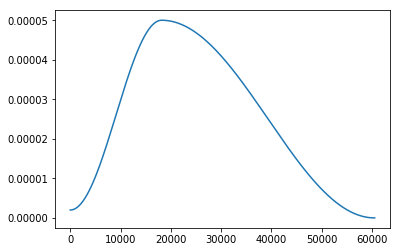

In [17]:
learn.recorder.plot_lr()

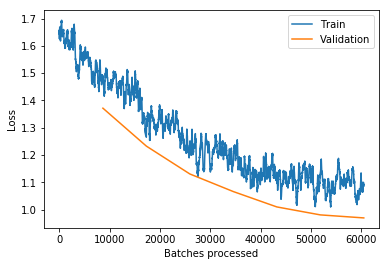

In [18]:
learn.recorder.plot_losses()

In [19]:
learn.save('transformer_run2_5en5');

### Run 2 overnight

In [15]:
learn.load('transformer_run2_5en5');
learn.unfreeze()

In [20]:
learn.fit_one_cycle(8, 1e-5, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,1.144125,0.972666,0.692148
2,1.021833,0.969859,0.693078
3,1.128476,0.960668,0.695349
4,1.074590,0.950423,0.697963
5,1.000433,0.939323,0.700942
6,1.095476,0.928870,0.703569
7,0.981362,0.924858,0.704761
8,1.079143,0.925328,0.704656


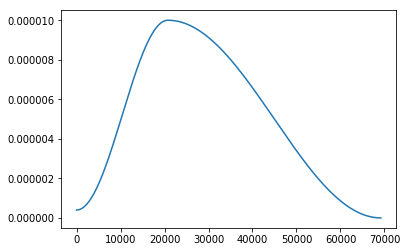

In [21]:
learn.recorder.plot_lr()

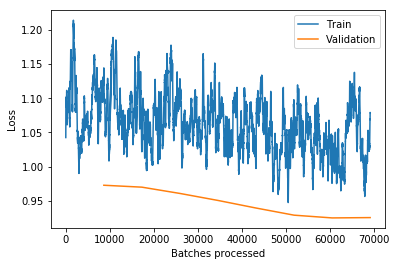

In [22]:
learn.recorder.plot_losses()

In [23]:
learn.save('transformer_run3_1en5_ep8');

In [ ]:
# 5e-4 starts to diverge at 30% - 1800 it / 8600

In [ ]:
# 1:35 per epoch